# &#x1F4D1; &nbsp;  Doodle Recognition Model

## Links
[`Keras. Deep Learning library for Theano and TensorFlow`](https://keras.io/)

## Libraries

In [43]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [44]:
import os,ast,h5py
import numpy,cv2,pandas,pylab

In [45]:
import keras as ks, tensorflow as tf
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

keras version: 2.2.4
tensorflow version: 1.12.0


In [46]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, DepthwiseConv2D

## Data

In [47]:
file_path = 'train_simplified/'
files = os.listdir(file_path)
labels = [el.replace(" ","_")[:-4] for el in files]
print(sorted(labels))

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'airplane', 'angel', 'animal_migration', 'arm', 'asparagus', 'bandage', 'barn', 'baseball', 'basket', 'beard', 'bed', 'bee', 'belt', 'bicycle', 'binoculars', 'bird', 'book', 'bracelet', 'broom', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'candle', 'canoe', 'car', 'carrot', 'castle', 'cello', 'chair', 'circle', 'clarinet', 'clock', 'computer', 'couch', 'cow', 'crab', 'crayon', 'crown', 'diving_board', 'dolphin', 'door', 'dragon', 'drill', 'duck', 'ear', 'elephant', 'envelope', 'eye', 'eyeglasses', 'fan', 'feather', 'fish', 'flashlight', 'flip_flops', 'garden', 'giraffe', 'golf_club', 'hamburger', 'hammer', 'harp', 'helmet', 'hexagon', 'hockey_puck', 'hot_dog', 'hot_tub', 'house', 'house_plant', 'hurricane', 'ice_cream', 'kangaroo', 'knee', 'lantern', 'laptop', 'leg', 'light_bulb', 'lion', 'lobster', 'lollipop', 'map', 'matches', 'motorbike', 'mouse', 'moustache', 'mushroom', 'nail', 'necklace'

In [48]:
I = 32 # image size in pixels
S = 1 # current number of the label set
T = 161 # number of labels in one set 
N = 1000 # number of images with the same label in the training set
data = pandas.DataFrame(index=range(N),columns=labels[(S-1)*T:S*T])
images = []

def get_image(data,time_color=True):
    data = ast.literal_eval(data)
    image = numpy.zeros((280,280),numpy.uint8)
    for t, s in enumerate(data):
        for i in range(len(s[0])-1):
            color = 255-min(t,10)*15 if time_color else 255
            _ = cv2.line(image,(s[0][i]+10,s[1][i]+10),(s[0][i+1]+10,s[1][i+1]+10),color,3)    
    return cv2.resize(image,(I,I))

for i in range((S-1)*T,S*T):
    label = labels[i]
    data[label] = pandas.read_csv(file_path+files[i],index_col='key_id').drawing.values[:N]
    images.extend([get_image(data[label].iloc[i]) for i in range(N)])
    data.drop([label],axis=1)
    
images = numpy.array(images)
images.shape

(161000, 32, 32)

In [49]:
targets = numpy.array([[]+N*[k] for k in range(T)])
targets = ks.utils.to_categorical(targets,T).reshape(N*T,T)
targets.shape

(161000, 161)

In [50]:
with h5py.File('DoodleImages.h5','w') as f:
    f.create_dataset('images',data=images/255)
    f.create_dataset('labels',data=targets)
    f.close()

In [58]:
f = h5py.File('DoodleImages.h5','r')
keys = list(f.keys()); keys

['images', 'labels']

In [59]:
images = numpy.array(f[keys[0]])
targets = numpy.array(f[keys[1]])
f.close()
images.shape,targets.shape

((161000, 32, 32), (161000, 161))

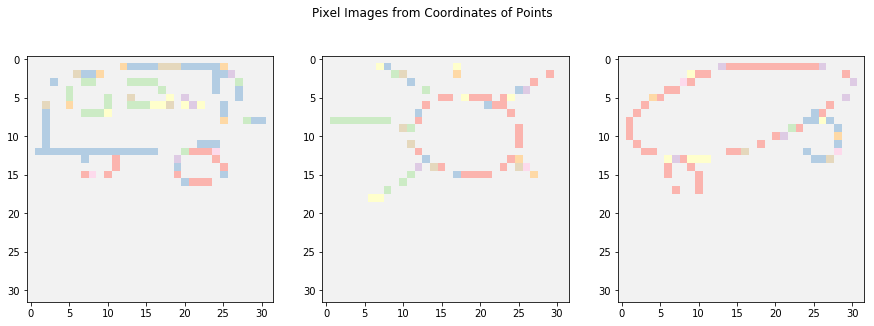

In [60]:
pylab.figure(figsize=(15,5))
pylab.subplot(1,3,1); pylab.imshow(images[0]/255,cmap=pylab.cm.Pastel1_r)
pylab.subplot(1,3,2); pylab.imshow(images[5000]/255,cmap=pylab.cm.Pastel1_r)
pylab.subplot(1,3,3); pylab.imshow(images[10000]/255,cmap=pylab.cm.Pastel1_r)
pylab.suptitle('Pixel Images from Coordinates of Points');

In [61]:
x_train,x_test,y_train,y_test = \
train_test_split(images,targets,test_size=0.2,random_state=1)
n = int(len(x_test)/2)
x_valid,y_valid = x_test[:n],y_test[:n]
x_test,y_test = x_test[n:],y_test[n:]

del images,targets

x_train = x_train.reshape(-1,I,I,1)
x_valid = x_valid.reshape(-1,I,I,1)
x_test = x_test.reshape(-1,I,I,1)
y_train.shape,y_valid.shape,y_test.shape

((128800, 161), (16100, 161), (16100, 161))

## Classification Models

In [64]:
def top_3_categorical_accuracy(y_true,y_pred):
    return ks.metrics.top_k_categorical_accuracy(y_true,y_pred,k=3)
def categorical_accuracy(y_true, y_pred):
    return ks.metrics.categorical_accuracy(y_true,y_pred)

def model():
    model = Sequential()
    
    model.add(DepthwiseConv2D(32,(5,5),padding='same',input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(DepthwiseConv2D(32,(1,1),padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Conv2D(32,(5,5),padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256,(5,5),padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(T))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='nadam', 
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])
    return model

In [65]:
model = model()
checkpointer = \
ModelCheckpoint(filepath='weights.doodles.hdf5',verbose=2,save_best_only=True)
lr_reduction = \
ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=0.5)
model.fit(x_train,y_train,epochs=10,batch_size=2048,verbose=2,
          validation_data=(x_valid,y_valid),callbacks=[checkpointer,lr_reduction]);

Train on 128800 samples, validate on 16100 samples
Epoch 1/10
 - 330s - loss: 4.9807 - categorical_accuracy: 0.0122 - top_3_categorical_accuracy: 0.0348 - val_loss: 4.9728 - val_categorical_accuracy: 0.0121 - val_top_3_categorical_accuracy: 0.0375

Epoch 00001: val_loss improved from inf to 4.97285, saving model to weights.doodles.hdf5
Epoch 2/10
 - 311s - loss: 4.5968 - categorical_accuracy: 0.0349 - top_3_categorical_accuracy: 0.0919 - val_loss: 4.3209 - val_categorical_accuracy: 0.0597 - val_top_3_categorical_accuracy: 0.1500

Epoch 00002: val_loss improved from 4.97285 to 4.32094, saving model to weights.doodles.hdf5
Epoch 3/10
 - 311s - loss: 4.2743 - categorical_accuracy: 0.0644 - top_3_categorical_accuracy: 0.1579 - val_loss: 4.2453 - val_categorical_accuracy: 0.0667 - val_top_3_categorical_accuracy: 0.1632

Epoch 00003: val_loss improved from 4.32094 to 4.24526, saving model to weights.doodles.hdf5
Epoch 4/10
 - 303s - loss: 4.1022 - categorical_accuracy: 0.0872 - top_3_categor

In [66]:
model.load_weights('weights.doodles.hdf5')
score = model.evaluate(x_test,y_test)
score

16100/16100 [==============================] - 31s 2ms/step


[3.1237380614191848, 0.2562111801242236, 0.4546583850931677]

In [ ]:
def model():
    model = Sequential()
    
    model.add(Conv2D(32,(5,5),padding='same',input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(T))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam', 
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])
    return model

In [ ]:
model = model()
checkpointer = \
ModelCheckpoint(filepath='weights.doodles.hdf5',verbose=2,save_best_only=True)
lr_reduction = \
ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=0.5)
model.fit(x_train,y_train,epochs=10,batch_size=2048,verbose=2,
          validation_data=(x_valid,y_valid),callbacks=[checkpointer,lr_reduction]);

In [ ]:
model.load_weights('weights.doodles.hdf5')
score = model.evaluate(x_test,y_test)
score